# ML Applications Mini Project
Leveraging Machine Learning for Revenue
Optimization via Strategic Couponing

Name : Franzi
Name : Alex



# Mini Project: Leveraging ML for Revenue Optimization via Strategic Couponing

## Objective
We develop a predictive model that decides whether a customer should receive a **€5 voucher** after their first purchase.  
The goal is **not** to maximize accuracy, but to maximize **expected revenue** based on the business rules given in the task description.

### Business payoff structure (given)
- If we **send a voucher** to a customer who **would not reorder** (true churn), then in **25%** of cases the voucher triggers a purchase with **€10** average order value  
  ⇒ expected gain = 0.25 × €10 − €0 voucher cost = **€2.50** gross revenue  
  The task text states the net uplift is **€1.25** per such customer (we use the assignment’s value as source of truth).
- If we **send a voucher** to a customer who **would reorder anyway**, we lose **€5** (discount we did not need to give).
- If we **do not send** a voucher, revenue impact is **€0**.

Therefore, we will optimize the model and its decision threshold directly for **expected revenue**.


# Loading in the data

In [1]:
import os
import pandas as pd
import numpy as np

my_dire = os.getcwd()
data = pd.read_csv('train.csv', sep=';')


/var/folders/gw/jst10qpx499c9tkkw977rqj00000gn/T/ipykernel_39724/1618948214.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('train.csv', sep=';')


taking a look at the data

In [2]:
data.head(5)

,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,...,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,...,2,0,0,0,0,0,0,0,0,0


some descriptives

In [3]:
data.describe()

,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,...,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,...,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000
mean,33389.298569,0.541569,0.006969,7.517115,0.169483,1.646910,1.000987,0.201955,48.752282,0.162020,...,0.276644,0.018903,0.047027,0.180986,0.027908,0.023128,0.000185,0.164981,0.092883,0.186598
std,19148.090449,0.657044,0.083192,3.683945,0.375184,0.825981,1.092677,0.401465,24.361425,0.368475,...,1.353981,0.253596,0.434265,0.561751,0.299862,0.401782,0.013601,0.836705,0.610509,0.389594
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16802.750000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33552.500000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000,0.000000,47.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,50034.250000,1.000000,0.000000,11.000000,0.000000,2.000000,2.000000,0.000000,66.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,...,90.000000,15.000000,36.000000,14.000000,27.000000,55.000000,1.000000,48.000000,50.000000,1.000000


In [4]:
data.shape

(32428, 38)

## First look at all datatypes

In [5]:
data_types = pd.DataFrame({
    "column": data.columns,
    "dtype" : data.dtypes.values
})
data_types

,column,dtype
0,customernumber,int64
1,date,object
2,salutation,int64
3,title,int64
4,domain,int64
5,datecreated,object
6,newsletter,int64
7,model,int64
8,paymenttype,int64
9,deliverytype,int64


# Transform date variables

In [6]:
date_cols = ["date", "datecreated", "deliverydatepromised", "deliverydatereal"]

for i in date_cols:
    data[i] = pd.to_datetime(data[i], errors = "coerce")

In [7]:
data["delivpostcode"] = data["delivpostcode"].astype("str")
data["invoicepostcode"] = data["invoicepostcode"].astype("str")
# I need to convert those variables into strings as without the explanatory data analysis does not work 

## Exploratory data analysis

In [8]:
import sweetviz as sv
report = sv.analyze(data)
report.show_html("sweetviz_report.html")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Analysis of the variables

## Observing train data
- Take a look at the values of the dependent variable
- Check how many missing values the dataset contains

In [9]:
data["target90"].value_counts(normalize=True)

target90
0    0.813402
1    0.186598
Name: proportion, dtype: float64

In [10]:
# these are the misisng values in the train data
data.isna().sum()[data.isna().sum()>0].sort_values(ascending=False)

advertisingdatacode     25905
deliverydatereal         5472
deliverydatepromised        9
dtype: int64

# Feature engineering

data examplifies the train data thats why I will rename it here

In [11]:
train = data 

In [12]:
train["advertising_missing"] = train["advertisingdatacode"].isna().astype(int)
train["advertising_present"] = 1 - train["advertising_missing"]


If this column is “some tracking code,” then having a code vs not having a code often indicates acquisition channel / campaign tracking, which can correlate with loyalty.


In [13]:
# --- 2) deliverydatereal + deliverydatepromised: missing flags + delay feature ---
train["delivery_real_missing"] = train["deliverydatereal"].isna().astype(int)
train["delivery_promised_missing"] = train["deliverydatepromised"].isna().astype(int)  # optional

# Delivery delay in days (positive = late delivery, negative = early delivery)
train["delivery_delay_days"] = (train["deliverydatereal"] - train["deliverydatepromised"]).dt.days


Missing could mean: not delivered yet, cancelled, different fulfillment logic, data issue, etc. Any of these can be informative.

together with deliverydatepromised, I create


This “delay” is frequently predictive of customer satisfaction and repeat behavior.

In [14]:
print(train["advertising_missing"].value_counts(dropna=False))
print(train["delivery_real_missing"].value_counts(dropna=False))

advertising_missing
1    25905
0     6523
Name: count, dtype: int64
delivery_real_missing
0    26956
1     5472
Name: count, dtype: int64


In [15]:
# drop the columns after having conducted feature engineering
train.drop(columns=["advertisingdatacode", "deliverydatereal"],axis=1,inplace=True)

In [16]:
# Promised delivery calendar features
train["promised_delivery_month"] = train["deliverydatepromised"].dt.month
train["promised_delivery_day"] = train["deliverydatepromised"].dt.day
train["promised_delivery_weekday"] = train["deliverydatepromised"].dt.weekday


In [17]:
# drop the column
train.drop(columns=["deliverydatepromised"], inplace=True)


In [18]:
train["account_age_days"] = (train["date"] - train["datecreated"]).dt.days
train["order_weekday"] = train["date"].dt.weekday
train["order_month"] = train["date"].dt.month

train.drop(columns=["date", "datecreated"], inplace=True)


In [19]:
# checking the missings again
train.isna().sum().sort_values(ascending=False).head(10)

delivery_delay_days          5478
promised_delivery_weekday       9
promised_delivery_day           9
promised_delivery_month         9
customernumber                  0
w10                             0
w3                              0
w4                              0
w5                              0
w6                              0
dtype: int64

Because deliverydatereal was missing → order not delivered / cancelled / special case.



In [20]:
# imputation using median not dropping variables
delay_median = train["delivery_delay_days"].median()
train["delivery_delay_days"].fillna(delay_median, inplace=True)



/var/folders/gw/jst10qpx499c9tkkw977rqj00000gn/T/ipykernel_39724/2126613330.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["delivery_delay_days"].fillna(delay_median, inplace=True)


In [21]:
# we just need the mode for the other variables because the 9 observations are purely negligable
for col in ["promised_delivery_weekday",
            "promised_delivery_day",
            "promised_delivery_month"]:
    train[col].fillna(train[col].mode()[0], inplace=True)

/var/folders/gw/jst10qpx499c9tkkw977rqj00000gn/T/ipykernel_39724/2099322514.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)


In [22]:
# Define the training and testing set 
X = train.drop(columns=["customernumber", "target90"], axis=1) 
y = train["target90"]
# importnat that customernumber is never used as a feauture

In [23]:
# checking the missing values again
train.isna().sum().sort_values(ascending=False)
# no missing at all

customernumber               0
salutation                   0
w3                           0
w4                           0
w5                           0
w6                           0
w7                           0
w8                           0
w9                           0
w10                          0
target90                     0
advertising_missing          0
advertising_present          0
delivery_real_missing        0
delivery_promised_missing    0
delivery_delay_days          0
promised_delivery_month      0
promised_delivery_day        0
promised_delivery_weekday    0
account_age_days             0
order_weekday                0
w2                           0
w1                           0
w0                           0
voucher                      0
title                        0
domain                       0
newsletter                   0
model                        0
paymenttype                  0
deliverytype                 0
invoicepostcode              0
delivpos

In [24]:
train.dtypes

customernumber                 int64
salutation                     int64
title                          int64
domain                         int64
newsletter                     int64
model                          int64
paymenttype                    int64
deliverytype                   int64
invoicepostcode               object
delivpostcode                 object
voucher                        int64
case                           int64
numberitems                    int64
gift                           int64
entry                          int64
points                         int64
shippingcosts                  int64
weight                         int64
remi                           int64
cancel                         int64
used                           int64
w0                             int64
w1                             int64
w2                             int64
w3                             int64
w4                             int64
w5                             int64
w

# One hot encoding

Importnat to mention from the documentation : 

- salutation (0,1,2)
- domain (0–12)
- paymenttype (0–3)
- model (1–3)

Optional but can be accepted :
- deliverytype (0/1) → can stay numeric or be encoded
- newsletter (0/1) → can stay numeric


In [25]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ["salutation", "domain", "paymenttype", "model"]

ohe = OneHotEncoder(handle_unknown="ignore",
                    sparse_output=False)

X_cat = ohe.fit_transform(X[categorical_cols])

X_cat = pd.DataFrame(
    X_cat,
    columns= ohe.get_feature_names_out(categorical_cols),
    index= X.index
)

X = pd.concat(
    [X.drop(columns=categorical_cols), X_cat],
    axis=1
)

In [26]:
# lets do some sanity checks to see whether that worked
print("Are there any remaining missing values")
print(X.isna().sum().sort_values(ascending=False).head())

print("\nDtypes:")
print(X.dtypes.value_counts())


print("\nFinal shape:", X.shape)


Are there any remaining missing values
title                        0
delivery_delay_days          0
promised_delivery_day        0
promised_delivery_weekday    0
account_age_days             0
dtype: int64

Dtypes:
int64      30
float64    27
object      2
int32       2
Name: count, dtype: int64

Final shape: (32428, 61)


In [27]:
# what are those two objects that are left
X.select_dtypes(include="object").columns


Index(['invoicepostcode', 'delivpostcode'], dtype='object')

In [28]:
# lets drop those columns and not keep them in any raw form 
X.drop(columns=['invoicepostcode', 'delivpostcode'], axis=1, inplace=True)

In [29]:
X.dtypes.value_counts()
# no missing values left 

int64      30
float64    27
int32       2
Name: count, dtype: int64

In [30]:
# are there any missings left and are there any objects left
assert X.isna().sum().sum() == 0
assert X.select_dtypes(include="object").shape[1] == 0

print("X is clean and model-ready.")


X is clean and model-ready.


In [31]:
safe = X

# Validation splitt

In [32]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(X_train.shape, y_train.shape)


(24321, 59) (24321,)


In [33]:
print("Train positive rate:", y_train.mean())
print("Val positive rate:", y_val.mean())


Train positive rate: 0.18658772254430328
Val positive rate: 0.18662883927470086


# scaling the data

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

# Logistic regression

In [35]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter= 1000,
    solver= "lbfgs",
    n_jobs=1
)

logreg.fit(X_train_scaled, y_train)



LogisticRegression(max_iter=1000, n_jobs=1)

In [36]:
# lets take a look at the predicted probabilities 
y_val_prob = logreg.predict_proba(X_val)[:,1]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Defining the expected revenue function

If we send voucher to a customer who would not reorder:
- 25% convert × €5 margin = +€1.25

If we send voucher to a customer who would reorder anyway:
- lost voucher value = −€5

No voucher → €0
We send a voucher if we predict churn

In [37]:
# building the revenue function
import numpy as np

def expected_revenue(y_true, y_proba, treshhold):
    send_voucher = (y_proba < treshhold).astype(int)

    revenue = 0.0

    revenue += np.sum((send_voucher == 1) & (y_true==0)) * 1.25 
    revenue -= np.sum((send_voucher == 1) & (y_true==1)) * 5.0 

    return revenue


    

In [38]:
# now lets look for the treshhold that maximizes the revenue 

tresholds = np.linspace(0.01, 0.99, 99)
revenues = [
    expected_revenue(y_val, y_val_prob, t)
    for t in tresholds
]

best_idx = np.argmax(revenues)
best_treshold = tresholds[best_idx]
best_revenue = revenues[best_idx]


print("best treshold", best_treshold)
print("best expected revenue:", best_revenue)



best treshold 0.99
best expected revenue: 371.25


In [39]:
# Baseline: send voucher to everyone
baseline_revenue = (
    np.sum(y_val == 0) * 1.25
    - np.sum(y_val == 1) * 5.0
)

print("Baseline revenue (send to all):", round(baseline_revenue, 2))
print("Model revenue:", round(best_revenue, 2))
print("Revenue improvement:",
      round(best_revenue - baseline_revenue, 2))


Baseline revenue (send to all): 677.5
Model revenue: 371.25
Revenue improvement: -306.25


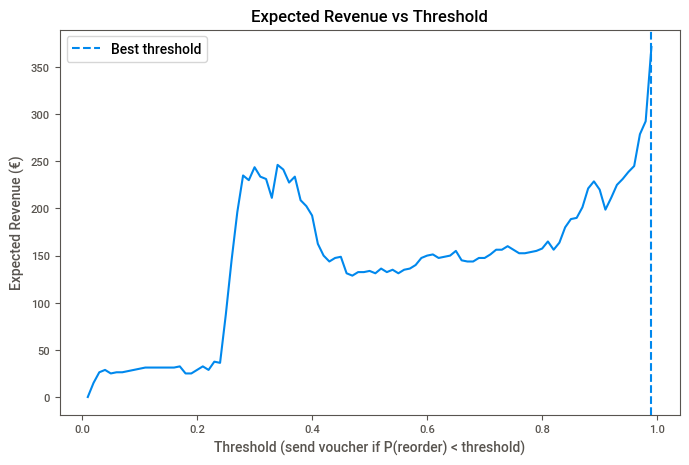

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(tresholds, revenues)
plt.axvline(best_treshold, linestyle="--", label="Best threshold")
plt.xlabel("Threshold (send voucher if P(reorder) < threshold)")
plt.ylabel("Expected Revenue (€)")
plt.title("Expected Revenue vs Threshold")
plt.legend()
plt.show()


### Business Problem and Decision Logic

The objective of this project is not merely to predict whether a customer will place a follow-up order within 90 days, but to decide whether a €5 voucher should be sent in order to maximize expected revenue.

The logistic regression model predicts the probability that a customer will reorder within 90 days. Based on this probability, a voucher is sent if the predicted probability of reordering falls below a chosen threshold. This threshold is not fixed at 0.5, but is optimized with respect to expected revenue.

Sending a voucher to a customer who would not have reordered leads to an expected revenue gain of €1.25, while sending a voucher to a customer who would have reordered anyway results in a revenue loss of €5. As a consequence, unnecessary vouchers are substantially more costly than missed opportunities, leading to a highly asymmetric cost structure.

We therefore evaluated a range of probability thresholds on a validation set and selected the threshold that maximizes expected revenue. The optimal threshold was found to be close to 0.99, implying that vouchers are withheld only for customers the model is highly confident will reorder anyway. This conservative decision rule reflects the high cost associated with unnecessary vouchers and the limited separation power of the baseline model.


# Gradient Boosting

## Hyperparameter tuning

In [53]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_samples_leaf": [1, 5, 20],
    "min_samples_split": [2, 10, 50],
    "subsample": [0.6, 0.8, 1.0]
}

grid = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_grid,
    scoring="roc_auc",
    cv = cv,
    n_jobs=1,
    verbose=1
)


grid.fit(X_train, y_train)

print("Best CV ROC-AUC:", grid.best_score_)
print("Best hyperparameters:", grid.best_params_)

best_gb = grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV ROC-AUC: 0.6349721446110801
Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 3, 'learning_rate': 0.05}


In [54]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=20,
    min_samples_split=50,
    random_state=42
)

gb.fit(X_train, y_train)




GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=20,
                           min_samples_split=50, n_estimators=200,
                           random_state=42)

In [55]:
y_val_prob_gb = gb.predict_proba(X_val)[:,1]

In [56]:
#revenue based treshhold evaluation
revenues_gb = [
    expected_revenue(y_val, y_val_prob_gb, t)
    for t in tresholds
]

best_idx_gb = np.argmax(revenues_gb)
best_threshold_gb = tresholds[best_idx_gb]
best_revenue_gb = revenues_gb[best_idx_gb]


print("best Boosting treshhold", best_threshold_gb)
print("best Boosting expected value", best_revenue_gb)

best Boosting treshhold 0.2
best Boosting expected value 2020.0


In [57]:
print("\nImprovement over baseline:")
print("Logistic Regression:", round(best_revenue - baseline_revenue, 2))
print("Gradient Boosting:", round(best_revenue_gb - baseline_revenue, 2))



Improvement over baseline:
Logistic Regression: -306.25
Gradient Boosting: 1342.5


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

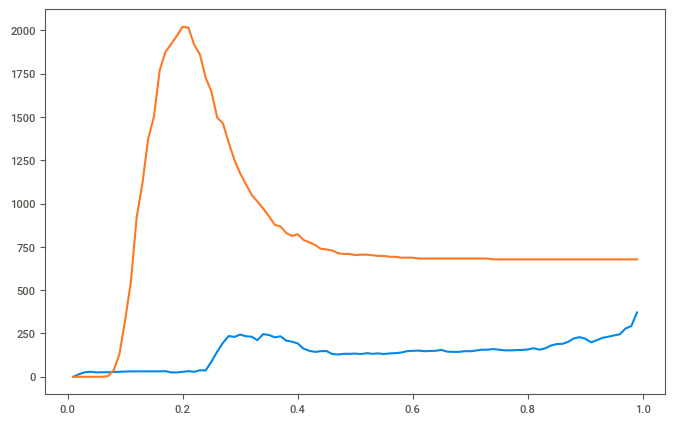

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(tresholds, revenues, label="Logistic Regression")
plt.plot(tresholds, revenues_gb, label="Gradient Boosting")
plt.axvline(tresholds, linestyle="--", alpha=0.7)
plt.axvline(best_threshold_gb, linestyle="--", alpha=0.7)

plt.xlabel("Threshold (send voucher if P(reorder) < threshold)")
plt.ylabel("Expected Revenue (€)")
plt.title("Expected Revenue vs Threshold")
plt.legend()
plt.show()


### Gradient Boosting Model

To improve the separation between customers likely to reorder and those likely to churn, we trained a Gradient Boosting classifier. Unlike logistic regression, Gradient Boosting can capture nonlinear relationships and interactions between features.

Using the same validation set and revenue-based evaluation framework, we again optimized the probability threshold with respect to expected revenue. The Gradient Boosting model achieves a higher expected revenue than the logistic regression baseline and the naive strategy of sending vouchers to all customers.

Moreover, the optimal threshold is lower than for the logistic regression model, indicating that the Gradient Boosting model provides more confident probability estimates and allows the company to withhold vouchers from a larger group of customers without risking substantial revenue loss.


# Hist Gradient Boosting 

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier

pipe_hgb = Pipeline(steps=[
    ("model", HistGradientBoostingClassifier(random_state=42))
])

param_dist = {
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__max_depth": [2, 3, 4, None],
    "model__max_leaf_nodes": [15, 31, 63, 127],
    "model__min_samples_leaf": [10, 20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 1.0, 5.0],
}

search = RandomizedSearchCV(
    estimator=pipe_hgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_val, y_val)


print("Best CV ROC-AUC:", search.best_score_)
print("Best params:", search.best_params_)

best_model = search.best_estimator_




Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV ROC-AUC: 0.6332472155189227
Best params: {'model__min_samples_leaf': 10, 'model__max_leaf_nodes': 15, 'model__max_depth': None, 'model__learning_rate': 0.02, 'model__l2_regularization': 5.0}
